In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots as sbp
import sys
sys.path += ["../src"]
import jl_vae
from glob import glob
from jl_synthetic_pop_all_provinces import add_cat_features
from tqdm import tqdm
from _51_abm_functions import cod_prov_abbrv_df
import utils

In [60]:
print("available provinces")
[u.split("_")[-1][:2] for u in glob(jl_vae.path_pop_synth + f"copula_samples/df_copula_nf95_*.csv")]

available provinces


['AG', 'BN', 'EN', 'CL']

In [ ]:
prov = "CL"

In [57]:
df_real = pd.read_csv(jl_vae.path_pop_synth + f"real_populations/df_real_{prov}.csv", index_col = 0)
df_real95 = df_real.sample(frac = 0.95, random_state = 1111)
df_excluded = df_real[~df_real.index.isin(df_real95.index)]


df_nfvae = pd.read_csv(jl_vae.path_pop_synth + f"pop_samples/synthetic_pop_full_250709price_{prov}.csv", index_col = 0)
df_vae = pd.read_csv(jl_vae.path_pop_synth + f"pop_samples_ablation/synthetic_pop_full_250710{prov}.csv", index_col = 0)

df_nfvae95 = pd.read_csv(jl_vae.path_pop_synth + f"95sample/pop_samples/synthetic_pop_full_250703{prov}.csv", index_col = 0)

df_copula_ablation = pd.read_csv(jl_vae.path_pop_synth + f"copula_samples/df_copula_ablation_{prov}.csv", index_col = 0)
df_copula_nf = pd.read_csv(jl_vae.path_pop_synth + f"copula_samples/df_copula_nf_{prov}.csv", index_col = 0)
df_copula_ablation95 = pd.read_csv(jl_vae.path_pop_synth + f"copula_samples/df_copula_ablation95_{prov}.csv", index_col = 0)
df_copula_nf95 = pd.read_csv(jl_vae.path_pop_synth + f"copula_samples/df_copula_nf95_{prov}.csv", index_col = 0)

df_ipf = pd.read_csv(jl_vae.path_pop_synth + f"ipf_samples/df_sample_{prov}_250718.csv", index_col = 0)
df_ipf95 = pd.read_csv(jl_vae.path_pop_synth + f"ipf_samples/df_sample95_{prov}_250718.csv", index_col = 0)


In [ ]:
all_baselines = {"df_real": df_real, 
                 "df_real95": df_real95, "df_nfvae": df_nfvae, "df_vae": df_vae, "df_nfvae95": df_nfvae95, "df_copula_ablation": df_copula_ablation,
                 "df_copula_nf": df_copula_nf, "df_copula_ablation95": df_copula_ablation95, "df_copula_nf95": df_copula_nf95, "df_ipf": df_ipf,
                 "df_ipf95": df_ipf95}
                 

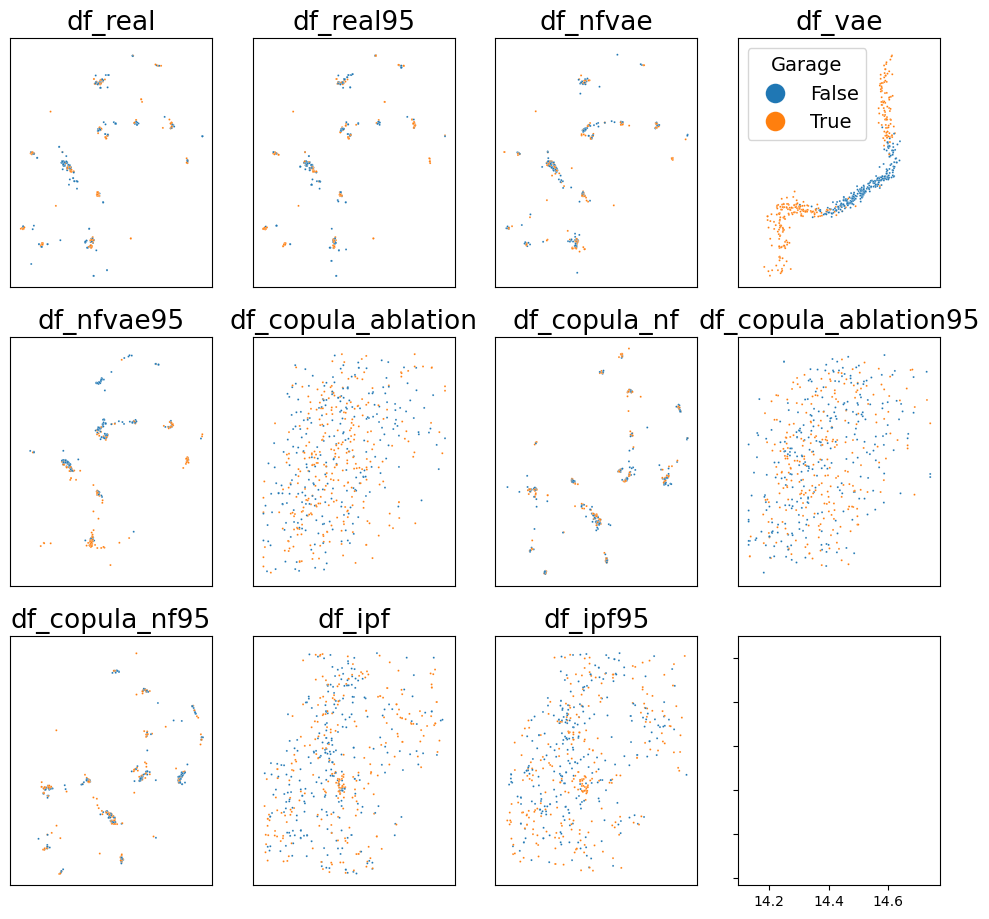

In [71]:
fig, axes = sbp(ncols = 4, nrows = 3, figsize = (12,11), sharex = True, sharey = True)

for k,fun in enumerate(all_baselines):
    df_plot = all_baselines[fun].sample(n = len(df_real), random_state = 1807, replace = True)
    i,j = divmod(k,4)
    sns.scatterplot(data = df_plot.assign(flag_garage = lambda x: (x["flag_garage"] + 0.) > 0),
                    hue = "flag_garage", 
                    # hue = "flag_garage", 
                    x = "x", y = "y", s = 2, ax = axes[i,j])
    # axes[j].set_title(prov + " " + ["Real", "Synthetic"][j])
    axes[i,j].set_title(fun, fontsize = 19)
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    axes[i,j].legend().set_visible(False)
axes[0,3].legend(fontsize = 14, markerscale = 10, title_fontsize = 14).set_title("Garage")        
    


In [54]:
# for prov in tqdm(cod_prov_abbrv_df.sort_values("prov_abbrv")["prov_abbrv"]):
#     try:
#         df_real = jl_vae.get_df_prov(prov, dropna = False, add_cols = ["log_price"])
#         df_real = df_real[[u for u in jl_vae.cols + ["log_price"] if u not in ["prov_abbrv"]] + ["x_norm", "y_norm"]].assign(flag_air_conditioning_Missing = lambda x: x["flag_air_conditioning"] == "Missing",
#                                                                                                                                     flag_multi_floor_Missing = lambda x: x["flag_multi_floor"] == "Missing").replace("Missing",0).astype(float)
#         df_real.drop(columns = [u for u in ["flag_geo_valid"] if u in df_real.columns], inplace = True)
        
#         df_real_geo = utils.spatial_matching_ABM(df_real, geo_dict["hydro_risk"], geo_dict["census"], 
#                                           geo_dict["omi_og"], geo_dict["cap"]).rename(columns = {"GEO_LATITUDINE_BENE_ROUNDED": "y", "GEO_LONGITUDINE_BENE_ROUNDED": "x"})
#         df_real_geo.drop(columns = [
#             'x_norm', 'y_norm', 'COD_CONTRATTO',
#             'flag_geo_valid', 'OMI_categ', 'scenario',
#             'scenario_HighRisk', 'scenario_LowRisk', 'scenario_MediumRisk',
#             'scenario_NoRisk', 'scenario_Risk', 'flag_italy', 'COD_PROV', 'COD_REG',
#             'regione_nome', 'prov_nome', 'year_erogaz_prov'], inplace = True)
#         df_real_geo.to_csv(f"/data/housing/data/intermediate/jl_pop_synth/real_populations/df_real_{prov}.csv")
#     except:
#         print(prov)